In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import pandas as pd
import os
from datasets import DatasetDict, Dataset
from transformers import AutoImageProcessor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import SwinForImageClassification, AutoImageProcessor  # Updated import
from transformers import DeiTFeatureExtractor, DeiTForImageClassification

In [2]:
# Define the paths to your training and testing datasets
train_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/train"  # Replace with the path to your training dataset
test_data_dir = "C:/Users/Amir/Desktop/skin cancer paper/skin cancer isic/Skin Cancer ISIC/Skin cancer ISIC The International Skin Imaging Collaboration/test"  # Replace with the path to your testing dataset

In [3]:
# Corrected imports
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from transformers import SwinForImageClassification, AutoImageProcessor

# DeiT-specific augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

# DeiT processor initialization
model_name = "facebook/deit-base-patch16-224"
feature_extractor = DeiTFeatureExtractor.from_pretrained(model_name)

# Preprocessing function
def preprocess_image(image):
    augmented = augmentations(image)
    processed = feature_extractor(
        augmented,
        return_tensors="pt"
    )["pixel_values"][0]
    return processed

# Create datasets
train_dataset = datasets.ImageFolder(train_data_dir, transform=preprocess_image)
test_dataset = datasets.ImageFolder(test_data_dir, transform=preprocess_image)


# ImageFolder applies `transform` to each image
train_dataset = datasets.ImageFolder(train_data_dir, transform=preprocess_image)
test_dataset = datasets.ImageFolder(test_data_dir, transform=preprocess_image)

# Split training data into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Check classes (ensure consistency)
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Print dataset sizes
print(f"Train size: {len(train_subset)}")
print(f"Val size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Number of classes: 9
Train size: 1791
Val size: 448
Test size: 118


C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Amir\.cache\huggingface\hub\models--facebook--deit-base-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\transformers\models\deit\feature_extr

In [9]:
# Initialize DeiT model with correct parameter handling
model = DeiTForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224",  # Using distilled version for better convergence
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# Modify classifier head properly
hidden_size = model.config.hidden_size
model.classifier = nn.Sequential(
    nn.LayerNorm(hidden_size),
    nn.Dropout(0.5),
    nn.Linear(hidden_size, num_classes)
)

# Initialize new layers properly
for name, module in model.classifier.named_modules():
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Amir\.cache\huggingface\hub\models--facebook--deit-base-distilled-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

In [10]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): L

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")  # Should be ~86M parameters

Total parameters: 85,808,649


In [12]:
import torch
import torch.optim as optim
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import torch.nn as nn
from transformers import SwinForImageClassification

# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay (L2 regularization)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.05)


# Define the optimizer with weight decay (L2 regularization)
#optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)







# Training loop settings
num_epochs = 100
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# CSV file for logging training metrics
csv_filename = "training_metrics.csv"
df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
df.to_csv(csv_filename, index=False)  # Initialize the CSV file

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        logits = outputs.logits  # Extract logits
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimizer step
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        train_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)
    
    # Compute epoch-level metrics
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct, total = 0, 0

    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logits = outputs.logits
            loss = criterion(logits, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total) * 100)

    # Compute epoch-level validation metrics
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Save metrics to CSV file
    df = pd.DataFrame([[epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy]],
                      columns=["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
    df.to_csv(csv_filename, mode='a', header=False, index=False)


Epoch [1/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, accuracy=35.2, loss=1.97]


Epoch [1/100], Train Loss: 2.1710, Train Accuracy: 35.23%


Epoch [1/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s, accuracy=59.8, loss=0.892]


Epoch [1/100], Val Loss: 1.2531, Val Accuracy: 59.82%


Epoch [2/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=59.5, loss=0.746]


Epoch [2/100], Train Loss: 1.2867, Train Accuracy: 59.52%


Epoch [2/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=67.6, loss=0.652]


Epoch [2/100], Val Loss: 0.9540, Val Accuracy: 67.63%


Epoch [3/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=66.4, loss=1.07] 


Epoch [3/100], Train Loss: 1.0504, Train Accuracy: 66.44%


Epoch [3/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s, accuracy=67.9, loss=0.616]


Epoch [3/100], Val Loss: 0.9802, Val Accuracy: 67.86%


Epoch [4/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.11s/it, accuracy=69.4, loss=0.808]


Epoch [4/100], Train Loss: 0.9507, Train Accuracy: 69.40%


Epoch [4/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, accuracy=71.4, loss=0.415]


Epoch [4/100], Val Loss: 0.8655, Val Accuracy: 71.43%


Epoch [5/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=74.4, loss=0.326]


Epoch [5/100], Train Loss: 0.7883, Train Accuracy: 74.37%


Epoch [5/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s, accuracy=72.8, loss=0.582]


Epoch [5/100], Val Loss: 0.9023, Val Accuracy: 72.77%


Epoch [6/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.14s/it, accuracy=77.5, loss=0.356]


Epoch [6/100], Train Loss: 0.6774, Train Accuracy: 77.50%


Epoch [6/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, accuracy=70.8, loss=0.588]


Epoch [6/100], Val Loss: 0.9913, Val Accuracy: 70.76%


Epoch [7/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=80.4, loss=0.732]


Epoch [7/100], Train Loss: 0.5800, Train Accuracy: 80.40%


Epoch [7/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=69.6, loss=0.477]


Epoch [7/100], Val Loss: 0.9816, Val Accuracy: 69.64%


Epoch [8/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.08s/it, accuracy=83.4, loss=0.614]


Epoch [8/100], Train Loss: 0.4814, Train Accuracy: 83.36%


Epoch [8/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.7, loss=0.582]


Epoch [8/100], Val Loss: 1.1301, Val Accuracy: 71.65%


Epoch [9/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=85.3, loss=0.342]


Epoch [9/100], Train Loss: 0.4170, Train Accuracy: 85.26%


Epoch [9/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=70.3, loss=0.707]


Epoch [9/100], Val Loss: 1.1026, Val Accuracy: 70.31%


Epoch [10/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=87, loss=0.344]   


Epoch [10/100], Train Loss: 0.4029, Train Accuracy: 86.99%


Epoch [10/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=67.2, loss=0.737]


Epoch [10/100], Val Loss: 1.0848, Val Accuracy: 67.19%


Epoch [11/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.11s/it, accuracy=89, loss=0.374]   


Epoch [11/100], Train Loss: 0.3071, Train Accuracy: 89.00%


Epoch [11/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s, accuracy=73.2, loss=0.593]


Epoch [11/100], Val Loss: 0.9869, Val Accuracy: 73.21%


Epoch [12/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=91.2, loss=0.222] 


Epoch [12/100], Train Loss: 0.2277, Train Accuracy: 91.23%


Epoch [12/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, accuracy=71.4, loss=0.723]


Epoch [12/100], Val Loss: 0.9990, Val Accuracy: 71.43%


Epoch [13/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=91.1, loss=0.249] 


Epoch [13/100], Train Loss: 0.2217, Train Accuracy: 91.12%


Epoch [13/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, accuracy=71.2, loss=0.62] 


Epoch [13/100], Val Loss: 1.0058, Val Accuracy: 71.21%


Epoch [14/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.09s/it, accuracy=92.4, loss=0.131] 


Epoch [14/100], Train Loss: 0.1834, Train Accuracy: 92.35%


Epoch [14/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, accuracy=71.4, loss=0.823]


Epoch [14/100], Val Loss: 1.0556, Val Accuracy: 71.43%


Epoch [15/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=92.4, loss=0.288] 


Epoch [15/100], Train Loss: 0.1944, Train Accuracy: 92.35%


Epoch [15/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, accuracy=72.8, loss=0.698]


Epoch [15/100], Val Loss: 1.0275, Val Accuracy: 72.77%


Epoch [16/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=92.5, loss=0.235] 


Epoch [16/100], Train Loss: 0.1983, Train Accuracy: 92.52%


Epoch [16/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s, accuracy=71.9, loss=0.742]


Epoch [16/100], Val Loss: 1.0163, Val Accuracy: 71.88%


Epoch [17/100] Training: 100%|██████████| 56/56 [01:04<00:00,  1.15s/it, accuracy=93.5, loss=0.193] 


Epoch [17/100], Train Loss: 0.1630, Train Accuracy: 93.52%


Epoch [17/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s, accuracy=71.2, loss=0.683]


Epoch [17/100], Val Loss: 1.0443, Val Accuracy: 71.21%


Epoch [18/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=93.4, loss=0.102] 


Epoch [18/100], Train Loss: 0.1646, Train Accuracy: 93.41%


Epoch [18/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s, accuracy=71.4, loss=0.595]


Epoch [18/100], Val Loss: 0.9902, Val Accuracy: 71.43%


Epoch [19/100] Training: 100%|██████████| 56/56 [01:04<00:00,  1.15s/it, accuracy=94, loss=0.216]   


Epoch [19/100], Train Loss: 0.1565, Train Accuracy: 93.97%


Epoch [19/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s, accuracy=72.1, loss=0.771]


Epoch [19/100], Val Loss: 0.9915, Val Accuracy: 72.10%


Epoch [20/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.14s/it, accuracy=93, loss=0.121]   


Epoch [20/100], Train Loss: 0.1689, Train Accuracy: 92.96%


Epoch [20/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s, accuracy=72.1, loss=0.738]


Epoch [20/100], Val Loss: 1.0540, Val Accuracy: 72.10%


Epoch [21/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=93, loss=0.0421]  


Epoch [21/100], Train Loss: 0.1699, Train Accuracy: 93.02%


Epoch [21/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s, accuracy=71.4, loss=0.738]


Epoch [21/100], Val Loss: 1.0761, Val Accuracy: 71.43%


Epoch [22/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=93.4, loss=0.376]  


Epoch [22/100], Train Loss: 0.1702, Train Accuracy: 93.36%


Epoch [22/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s, accuracy=73, loss=0.574]  


Epoch [22/100], Val Loss: 1.0210, Val Accuracy: 72.99%


Epoch [23/100] Training: 100%|██████████| 56/56 [01:04<00:00,  1.15s/it, accuracy=93.4, loss=0.105] 


Epoch [23/100], Train Loss: 0.1547, Train Accuracy: 93.41%


Epoch [23/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s, accuracy=73.7, loss=0.643]


Epoch [23/100], Val Loss: 0.9603, Val Accuracy: 73.66%


Epoch [24/100] Training: 100%|██████████| 56/56 [01:04<00:00,  1.15s/it, accuracy=92.6, loss=0.204] 


Epoch [24/100], Train Loss: 0.1662, Train Accuracy: 92.63%


Epoch [24/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s, accuracy=73.7, loss=0.632]


Epoch [24/100], Val Loss: 1.0257, Val Accuracy: 73.66%


Epoch [25/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.10s/it, accuracy=93.1, loss=0.0672]


Epoch [25/100], Train Loss: 0.1551, Train Accuracy: 93.13%


Epoch [25/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, accuracy=72.8, loss=0.784]


Epoch [25/100], Val Loss: 0.9973, Val Accuracy: 72.77%


Epoch [26/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, accuracy=92.7, loss=0.154] 


Epoch [26/100], Train Loss: 0.1761, Train Accuracy: 92.74%


Epoch [26/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, accuracy=72.8, loss=0.665]


Epoch [26/100], Val Loss: 1.0016, Val Accuracy: 72.77%


Epoch [27/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, accuracy=93.5, loss=0.0961]


Epoch [27/100], Train Loss: 0.1542, Train Accuracy: 93.47%


Epoch [27/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s, accuracy=73, loss=0.715]  


Epoch [27/100], Val Loss: 1.0308, Val Accuracy: 72.99%


Epoch [28/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.11s/it, accuracy=94, loss=0.143]   


Epoch [28/100], Train Loss: 0.1540, Train Accuracy: 94.03%


Epoch [28/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.57it/s, accuracy=72.5, loss=0.713]


Epoch [28/100], Val Loss: 0.9707, Val Accuracy: 72.54%


Epoch [29/100] Training: 100%|██████████| 56/56 [01:02<00:00,  1.12s/it, accuracy=93.5, loss=0.197] 


Epoch [29/100], Train Loss: 0.1657, Train Accuracy: 93.47%


Epoch [29/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, accuracy=72.5, loss=0.831]


Epoch [29/100], Val Loss: 1.0551, Val Accuracy: 72.54%


Epoch [30/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=93, loss=0.164]   


Epoch [30/100], Train Loss: 0.1736, Train Accuracy: 92.96%


Epoch [30/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.55it/s, accuracy=72.5, loss=0.714]


Epoch [30/100], Val Loss: 1.0560, Val Accuracy: 72.54%


Epoch [31/100] Training: 100%|██████████| 56/56 [01:03<00:00,  1.13s/it, accuracy=93.5, loss=0.232] 


Epoch [31/100], Train Loss: 0.1588, Train Accuracy: 93.52%


Epoch [31/100] Validation: 100%|██████████| 14/14 [00:09<00:00,  1.52it/s, accuracy=71, loss=0.737]  


Epoch [31/100], Val Loss: 1.0499, Val Accuracy: 70.98%


Epoch [32/100] Training: 100%|██████████| 56/56 [01:01<00:00,  1.09s/it, accuracy=93.1, loss=0.16]  


Epoch [32/100], Train Loss: 0.1568, Train Accuracy: 93.13%


Epoch [32/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=72.3, loss=0.656]


Epoch [32/100], Val Loss: 0.9851, Val Accuracy: 72.32%


Epoch [33/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=94.2, loss=0.167] 


Epoch [33/100], Train Loss: 0.1327, Train Accuracy: 94.25%


Epoch [33/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=71.7, loss=0.72] 


Epoch [33/100], Val Loss: 1.0279, Val Accuracy: 71.65%


Epoch [34/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=92.6, loss=0.165] 


Epoch [34/100], Train Loss: 0.1641, Train Accuracy: 92.63%


Epoch [34/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=72.1, loss=0.726]


Epoch [34/100], Val Loss: 1.0258, Val Accuracy: 72.10%


Epoch [35/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.1, loss=0.0894]


Epoch [35/100], Train Loss: 0.1632, Train Accuracy: 93.13%


Epoch [35/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=73, loss=0.591]  


Epoch [35/100], Val Loss: 0.9988, Val Accuracy: 72.99%


Epoch [36/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.124] 


Epoch [36/100], Train Loss: 0.1567, Train Accuracy: 93.47%


Epoch [36/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=71.2, loss=0.853]


Epoch [36/100], Val Loss: 1.0048, Val Accuracy: 71.21%


Epoch [37/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93, loss=0.344]   


Epoch [37/100], Train Loss: 0.1583, Train Accuracy: 92.96%


Epoch [37/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=71.7, loss=0.634]


Epoch [37/100], Val Loss: 1.0396, Val Accuracy: 71.65%


Epoch [38/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.1, loss=0.261] 


Epoch [38/100], Train Loss: 0.1710, Train Accuracy: 93.13%


Epoch [38/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=71, loss=0.803]  


Epoch [38/100], Val Loss: 1.0356, Val Accuracy: 70.98%


Epoch [39/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.4, loss=0.0931]


Epoch [39/100], Train Loss: 0.1531, Train Accuracy: 93.41%


Epoch [39/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=71.4, loss=0.767]


Epoch [39/100], Val Loss: 1.0364, Val Accuracy: 71.43%


Epoch [40/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.21]  


Epoch [40/100], Train Loss: 0.1651, Train Accuracy: 93.47%


Epoch [40/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.8, loss=0.782]


Epoch [40/100], Val Loss: 1.0740, Val Accuracy: 72.77%


Epoch [41/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93, loss=0.201]   


Epoch [41/100], Train Loss: 0.1712, Train Accuracy: 93.02%


Epoch [41/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.3, loss=0.553]


Epoch [41/100], Val Loss: 0.9909, Val Accuracy: 72.32%


Epoch [42/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.328] 


Epoch [42/100], Train Loss: 0.1526, Train Accuracy: 93.52%


Epoch [42/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=72.1, loss=0.602]


Epoch [42/100], Val Loss: 1.0172, Val Accuracy: 72.10%


Epoch [43/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.4, loss=0.179]  


Epoch [43/100], Train Loss: 0.1665, Train Accuracy: 93.36%


Epoch [43/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=73.4, loss=0.728]


Epoch [43/100], Val Loss: 1.0312, Val Accuracy: 73.44%


Epoch [44/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=94.1, loss=0.177] 


Epoch [44/100], Train Loss: 0.1390, Train Accuracy: 94.08%


Epoch [44/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=74.3, loss=0.677]


Epoch [44/100], Val Loss: 1.0137, Val Accuracy: 74.33%


Epoch [45/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.2, loss=0.0524]


Epoch [45/100], Train Loss: 0.1609, Train Accuracy: 93.24%


Epoch [45/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=74.6, loss=0.739]


Epoch [45/100], Val Loss: 1.0002, Val Accuracy: 74.55%


Epoch [46/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=92.7, loss=0.238] 


Epoch [46/100], Train Loss: 0.1632, Train Accuracy: 92.69%


Epoch [46/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.1, loss=0.735]


Epoch [46/100], Val Loss: 1.0356, Val Accuracy: 72.10%


Epoch [47/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.8, loss=0.173] 


Epoch [47/100], Train Loss: 0.1500, Train Accuracy: 93.80%


Epoch [47/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=72.1, loss=0.774]


Epoch [47/100], Val Loss: 1.0737, Val Accuracy: 72.10%


Epoch [48/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.211] 


Epoch [48/100], Train Loss: 0.1666, Train Accuracy: 93.47%


Epoch [48/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=71.7, loss=0.678]


Epoch [48/100], Val Loss: 1.0588, Val Accuracy: 71.65%


Epoch [49/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=94.1, loss=0.307] 


Epoch [49/100], Train Loss: 0.1569, Train Accuracy: 94.08%


Epoch [49/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=73.2, loss=0.686]


Epoch [49/100], Val Loss: 1.0004, Val Accuracy: 73.21%


Epoch [50/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93, loss=0.0843]  


Epoch [50/100], Train Loss: 0.1547, Train Accuracy: 93.02%


Epoch [50/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.9, loss=0.642]


Epoch [50/100], Val Loss: 1.0182, Val Accuracy: 71.88%


Epoch [51/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=92.7, loss=0.313] 


Epoch [51/100], Train Loss: 0.1735, Train Accuracy: 92.74%


Epoch [51/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=71.4, loss=0.781]


Epoch [51/100], Val Loss: 1.0132, Val Accuracy: 71.43%


Epoch [52/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.0412]


Epoch [52/100], Train Loss: 0.1621, Train Accuracy: 93.52%


Epoch [52/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.3, loss=0.689]


Epoch [52/100], Val Loss: 0.9736, Val Accuracy: 72.32%


Epoch [53/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.6, loss=0.236] 


Epoch [53/100], Train Loss: 0.1538, Train Accuracy: 93.63%


Epoch [53/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=72.5, loss=0.657]


Epoch [53/100], Val Loss: 1.0378, Val Accuracy: 72.54%


Epoch [54/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.3, loss=0.423] 


Epoch [54/100], Train Loss: 0.1780, Train Accuracy: 93.30%


Epoch [54/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=71.7, loss=0.619]


Epoch [54/100], Val Loss: 1.0629, Val Accuracy: 71.65%


Epoch [55/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, accuracy=93.1, loss=0.199] 


Epoch [55/100], Train Loss: 0.1576, Train Accuracy: 93.08%


Epoch [55/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.7, loss=0.674]


Epoch [55/100], Val Loss: 1.0637, Val Accuracy: 71.65%


Epoch [56/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.6, loss=0.0771] 


Epoch [56/100], Train Loss: 0.1473, Train Accuracy: 93.58%


Epoch [56/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=72.5, loss=0.666]


Epoch [56/100], Val Loss: 0.9962, Val Accuracy: 72.54%


Epoch [57/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.7, loss=0.23]  


Epoch [57/100], Train Loss: 0.1539, Train Accuracy: 93.75%


Epoch [57/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=71.7, loss=0.783]


Epoch [57/100], Val Loss: 1.0856, Val Accuracy: 71.65%


Epoch [58/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=94, loss=0.134]    


Epoch [58/100], Train Loss: 0.1501, Train Accuracy: 94.03%


Epoch [58/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.4, loss=0.826]


Epoch [58/100], Val Loss: 1.0627, Val Accuracy: 71.43%


Epoch [59/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=92.7, loss=0.155] 


Epoch [59/100], Train Loss: 0.1649, Train Accuracy: 92.74%


Epoch [59/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=72.8, loss=0.626]


Epoch [59/100], Val Loss: 1.0313, Val Accuracy: 72.77%


Epoch [60/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.3, loss=0.248] 


Epoch [60/100], Train Loss: 0.1414, Train Accuracy: 93.30%


Epoch [60/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=71.9, loss=0.577]


Epoch [60/100], Val Loss: 0.9870, Val Accuracy: 71.88%


Epoch [61/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.7, loss=0.213] 


Epoch [61/100], Train Loss: 0.1460, Train Accuracy: 93.75%


Epoch [61/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.3, loss=0.749]


Epoch [61/100], Val Loss: 1.0001, Val Accuracy: 72.32%


Epoch [62/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.0766]


Epoch [62/100], Train Loss: 0.1567, Train Accuracy: 93.52%


Epoch [62/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=73.7, loss=0.661]


Epoch [62/100], Val Loss: 1.0116, Val Accuracy: 73.66%


Epoch [63/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.338] 


Epoch [63/100], Train Loss: 0.1648, Train Accuracy: 93.52%


Epoch [63/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=73.2, loss=0.663]


Epoch [63/100], Val Loss: 1.0198, Val Accuracy: 73.21%


Epoch [64/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=92.9, loss=0.0918]


Epoch [64/100], Train Loss: 0.1756, Train Accuracy: 92.85%


Epoch [64/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=71.7, loss=0.638]


Epoch [64/100], Val Loss: 1.0117, Val Accuracy: 71.65%


Epoch [65/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=92.8, loss=0.256] 


Epoch [65/100], Train Loss: 0.1520, Train Accuracy: 92.80%


Epoch [65/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.1, loss=0.702]


Epoch [65/100], Val Loss: 1.0319, Val Accuracy: 72.10%


Epoch [66/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.9, loss=0.194] 


Epoch [66/100], Train Loss: 0.1476, Train Accuracy: 93.91%


Epoch [66/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=73.2, loss=0.704]


Epoch [66/100], Val Loss: 1.0026, Val Accuracy: 73.21%


Epoch [67/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.4, loss=0.0309]


Epoch [67/100], Train Loss: 0.1533, Train Accuracy: 93.41%


Epoch [67/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.4, loss=0.77] 


Epoch [67/100], Val Loss: 1.0286, Val Accuracy: 71.43%


Epoch [68/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=92.9, loss=0.0736] 


Epoch [68/100], Train Loss: 0.1565, Train Accuracy: 92.91%


Epoch [68/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.7, loss=0.686]


Epoch [68/100], Val Loss: 1.0062, Val Accuracy: 71.65%


Epoch [69/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=94, loss=0.045]   


Epoch [69/100], Train Loss: 0.1505, Train Accuracy: 93.97%


Epoch [69/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=70.8, loss=0.701]


Epoch [69/100], Val Loss: 1.0044, Val Accuracy: 70.76%


Epoch [70/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.2, loss=0.215] 


Epoch [70/100], Train Loss: 0.1635, Train Accuracy: 93.19%


Epoch [70/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.1, loss=0.693]


Epoch [70/100], Val Loss: 1.0735, Val Accuracy: 72.10%


Epoch [71/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.2, loss=0.17]  


Epoch [71/100], Train Loss: 0.1599, Train Accuracy: 93.24%


Epoch [71/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.8, loss=0.775]


Epoch [71/100], Val Loss: 1.0421, Val Accuracy: 72.77%


Epoch [72/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.2, loss=0.259] 


Epoch [72/100], Train Loss: 0.1546, Train Accuracy: 93.19%


Epoch [72/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, accuracy=71.4, loss=0.604]


Epoch [72/100], Val Loss: 1.0383, Val Accuracy: 71.43%


Epoch [73/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.2, loss=0.211] 


Epoch [73/100], Train Loss: 0.1637, Train Accuracy: 93.19%


Epoch [73/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=73.9, loss=0.832]


Epoch [73/100], Val Loss: 1.0189, Val Accuracy: 73.88%


Epoch [74/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.8, loss=0.0377] 


Epoch [74/100], Train Loss: 0.1533, Train Accuracy: 93.80%


Epoch [74/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.9, loss=0.672]


Epoch [74/100], Val Loss: 1.0266, Val Accuracy: 71.88%


Epoch [75/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.2, loss=0.115] 


Epoch [75/100], Train Loss: 0.1484, Train Accuracy: 93.24%


Epoch [75/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.2, loss=0.558]


Epoch [75/100], Val Loss: 1.0344, Val Accuracy: 71.21%


Epoch [76/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=94, loss=0.227]   


Epoch [76/100], Train Loss: 0.1436, Train Accuracy: 93.97%


Epoch [76/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=70.5, loss=0.59] 


Epoch [76/100], Val Loss: 1.0118, Val Accuracy: 70.54%


Epoch [77/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.6, loss=0.0659] 


Epoch [77/100], Train Loss: 0.1500, Train Accuracy: 93.63%


Epoch [77/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.7, loss=0.623]


Epoch [77/100], Val Loss: 1.0485, Val Accuracy: 71.65%


Epoch [78/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.6, loss=0.162] 


Epoch [78/100], Train Loss: 0.1505, Train Accuracy: 93.63%


Epoch [78/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.5, loss=0.571]


Epoch [78/100], Val Loss: 1.0255, Val Accuracy: 72.54%


Epoch [79/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93, loss=0.0435]  


Epoch [79/100], Train Loss: 0.1623, Train Accuracy: 92.96%


Epoch [79/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=69.9, loss=0.63] 


Epoch [79/100], Val Loss: 1.0378, Val Accuracy: 69.87%


Epoch [80/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.27]  


Epoch [80/100], Train Loss: 0.1669, Train Accuracy: 93.47%


Epoch [80/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.5, loss=0.705]


Epoch [80/100], Val Loss: 1.0300, Val Accuracy: 72.54%


Epoch [81/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.5, loss=0.124] 


Epoch [81/100], Train Loss: 0.1616, Train Accuracy: 93.47%


Epoch [81/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.5, loss=0.694]


Epoch [81/100], Val Loss: 1.0872, Val Accuracy: 72.54%


Epoch [82/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.268] 


Epoch [82/100], Train Loss: 0.1584, Train Accuracy: 93.47%


Epoch [82/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.1, loss=0.745]


Epoch [82/100], Val Loss: 1.0270, Val Accuracy: 72.10%


Epoch [83/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.5, loss=0.138] 


Epoch [83/100], Train Loss: 0.1551, Train Accuracy: 93.47%


Epoch [83/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s, accuracy=72.8, loss=0.519]


Epoch [83/100], Val Loss: 1.0477, Val Accuracy: 72.77%


Epoch [84/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.7, loss=0.216] 


Epoch [84/100], Train Loss: 0.1567, Train Accuracy: 93.75%


Epoch [84/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=74.1, loss=0.764]


Epoch [84/100], Val Loss: 0.9792, Val Accuracy: 74.11%


Epoch [85/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=92.9, loss=0.236] 


Epoch [85/100], Train Loss: 0.1607, Train Accuracy: 92.85%


Epoch [85/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=73, loss=0.849]  


Epoch [85/100], Val Loss: 1.0492, Val Accuracy: 72.99%


Epoch [86/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93, loss=0.00592] 


Epoch [86/100], Train Loss: 0.1612, Train Accuracy: 92.96%


Epoch [86/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.8, loss=0.744]


Epoch [86/100], Val Loss: 1.0572, Val Accuracy: 72.77%


Epoch [87/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.5, loss=0.0507]


Epoch [87/100], Train Loss: 0.1510, Train Accuracy: 93.47%


Epoch [87/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=71.9, loss=0.647]


Epoch [87/100], Val Loss: 0.9753, Val Accuracy: 71.88%


Epoch [88/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.4, loss=0.337] 


Epoch [88/100], Train Loss: 0.1621, Train Accuracy: 93.36%


Epoch [88/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=72.1, loss=0.712]


Epoch [88/100], Val Loss: 1.0699, Val Accuracy: 72.10%


Epoch [89/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.5, loss=0.0608] 


Epoch [89/100], Train Loss: 0.1664, Train Accuracy: 93.47%


Epoch [89/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=73.7, loss=0.775]


Epoch [89/100], Val Loss: 1.0544, Val Accuracy: 73.66%


Epoch [90/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=92.7, loss=0.0563]


Epoch [90/100], Train Loss: 0.1801, Train Accuracy: 92.69%


Epoch [90/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.8, loss=0.663]


Epoch [90/100], Val Loss: 1.0136, Val Accuracy: 72.77%


Epoch [91/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.4, loss=0.0629] 


Epoch [91/100], Train Loss: 0.1556, Train Accuracy: 93.41%


Epoch [91/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=70.8, loss=0.617]


Epoch [91/100], Val Loss: 1.0286, Val Accuracy: 70.76%


Epoch [92/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=92.9, loss=0.333] 


Epoch [92/100], Train Loss: 0.1677, Train Accuracy: 92.91%


Epoch [92/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=73.2, loss=0.608]


Epoch [92/100], Val Loss: 0.9720, Val Accuracy: 73.21%


Epoch [93/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.6, loss=0.191] 


Epoch [93/100], Train Loss: 0.1635, Train Accuracy: 93.58%


Epoch [93/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=72.1, loss=0.684]


Epoch [93/100], Val Loss: 1.0335, Val Accuracy: 72.10%


Epoch [94/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=92.6, loss=0.203] 


Epoch [94/100], Train Loss: 0.1822, Train Accuracy: 92.63%


Epoch [94/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=71.7, loss=0.608]


Epoch [94/100], Val Loss: 1.0226, Val Accuracy: 71.65%


Epoch [95/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.7, loss=0.264] 


Epoch [95/100], Train Loss: 0.1626, Train Accuracy: 93.75%


Epoch [95/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=71.4, loss=0.651]


Epoch [95/100], Val Loss: 1.0253, Val Accuracy: 71.43%


Epoch [96/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.4, loss=0.223] 


Epoch [96/100], Train Loss: 0.1765, Train Accuracy: 93.36%


Epoch [96/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, accuracy=72.1, loss=0.712]


Epoch [96/100], Val Loss: 1.0079, Val Accuracy: 72.10%


Epoch [97/100] Training: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, accuracy=93.5, loss=0.0806]


Epoch [97/100], Train Loss: 0.1672, Train Accuracy: 93.47%


Epoch [97/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, accuracy=71.2, loss=0.699]


Epoch [97/100], Val Loss: 1.1054, Val Accuracy: 71.21%


Epoch [98/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.4, loss=0.252] 


Epoch [98/100], Train Loss: 0.1488, Train Accuracy: 93.36%


Epoch [98/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=73, loss=0.786]  


Epoch [98/100], Val Loss: 0.9882, Val Accuracy: 72.99%


Epoch [99/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.5, loss=0.208] 


Epoch [99/100], Train Loss: 0.1537, Train Accuracy: 93.52%


Epoch [99/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, accuracy=73, loss=0.646]  


Epoch [99/100], Val Loss: 1.0064, Val Accuracy: 72.99%


Epoch [100/100] Training: 100%|██████████| 56/56 [01:00<00:00,  1.07s/it, accuracy=93.4, loss=0.13]   


Epoch [100/100], Train Loss: 0.1552, Train Accuracy: 93.41%


Epoch [100/100] Validation: 100%|██████████| 14/14 [00:08<00:00,  1.64it/s, accuracy=72.8, loss=0.619]

Epoch [100/100], Val Loss: 0.9823, Val Accuracy: 72.77%


In [13]:
# Save the model's state dictionary
torch.save(model.state_dict(), "skin_cancer_model-Deit.pth")

print("Model saved successfully!")

Model saved successfully!


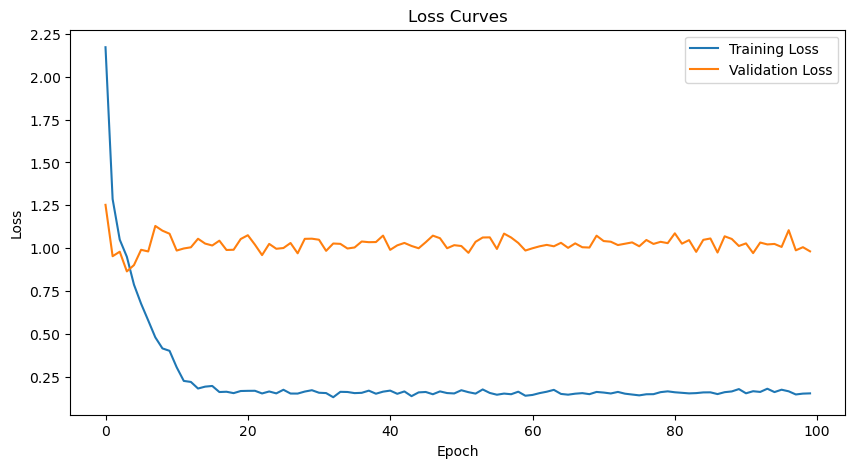

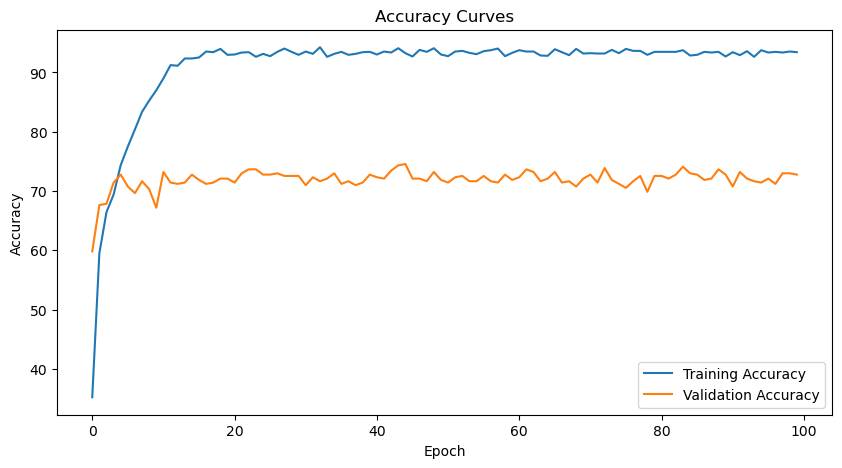

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Disable gradient computation for testing
with torch.no_grad():
    # Wrap test_loader with tqdm for a progress bar
    test_loop = tqdm(test_loader, desc="Testing SwinViT", ncols=100)
    for images, labels in test_loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Vision Transformer model
        outputs = model(images)  # This will return an object, not just the logits
        
        # Access the logits from the model's output object
        logits = outputs.logits  

        # Compute loss
        loss = criterion(logits, labels)

        # Accumulate loss
        test_loss += loss.item() * images.size(0)  # Scale loss by batch size

        # Compute accuracy
        _, predicted = torch.max(logits.detach(), 1)  # Use .detach() instead of .data
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update the progress bar with loss and accuracy
        test_loop.set_postfix(loss=test_loss / total, accuracy=(correct / total) * 100)

# Compute final test loss and accuracy
test_loss /= total  # Normalize loss properly
test_accuracy = 100 * correct / total

# Print the results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Testing SwinViT: 100%|██████████████████████| 4/4 [00:07<00:00,  1.85s/it, accuracy=60.2, loss=2.05]

Test Loss: 2.0525, Test Accuracy: 60.17%


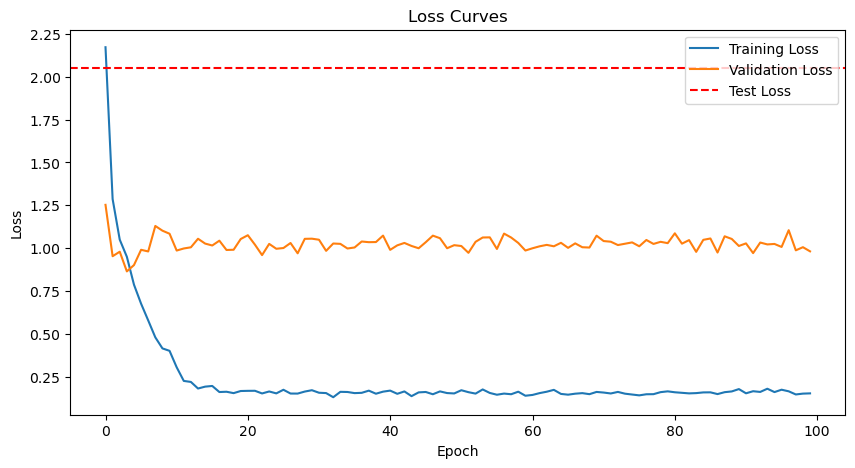

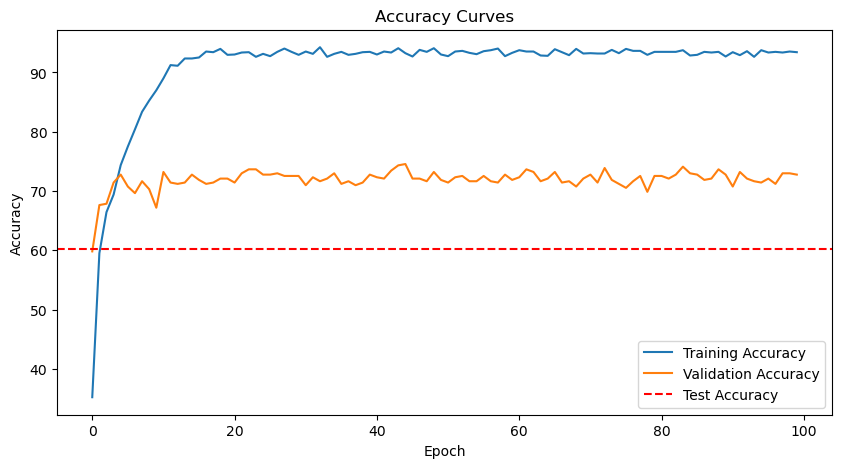

In [16]:
import matplotlib.pyplot as plt

# Plot training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plot training, validation, and test accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.show()

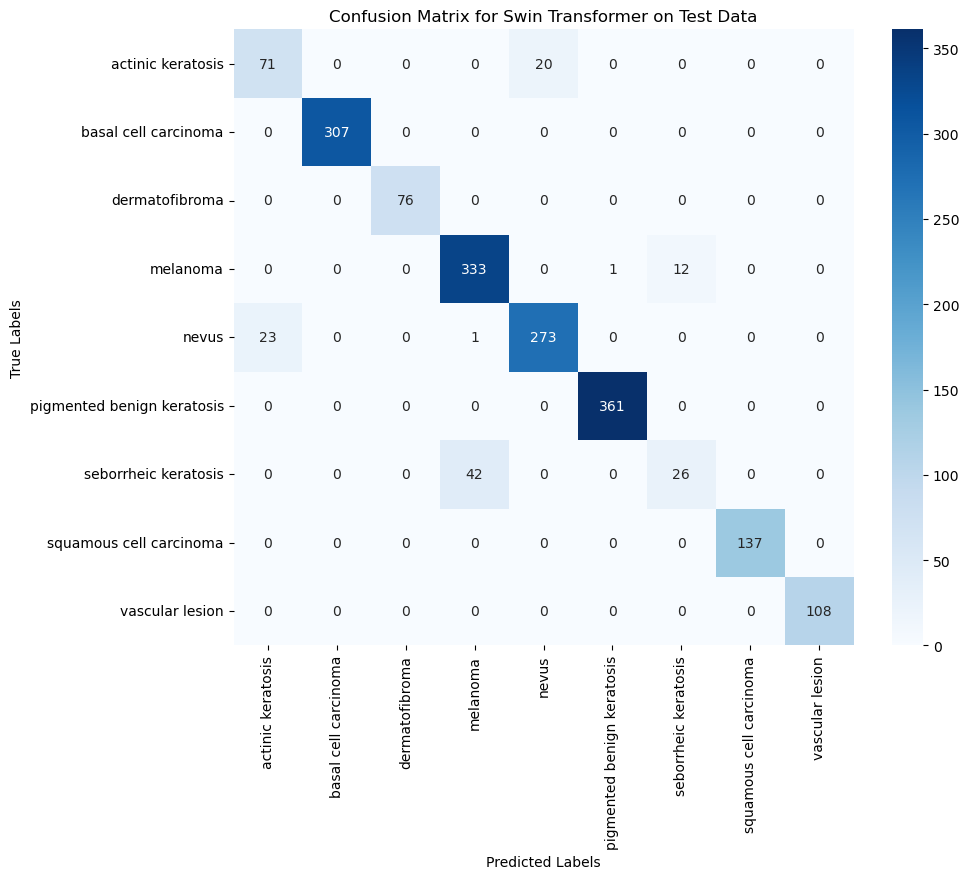

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use test_loader for unseen data
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)
        
        # Extract logits
        logits = outputs.logits

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Swin Transformer on Test Data')
plt.show()


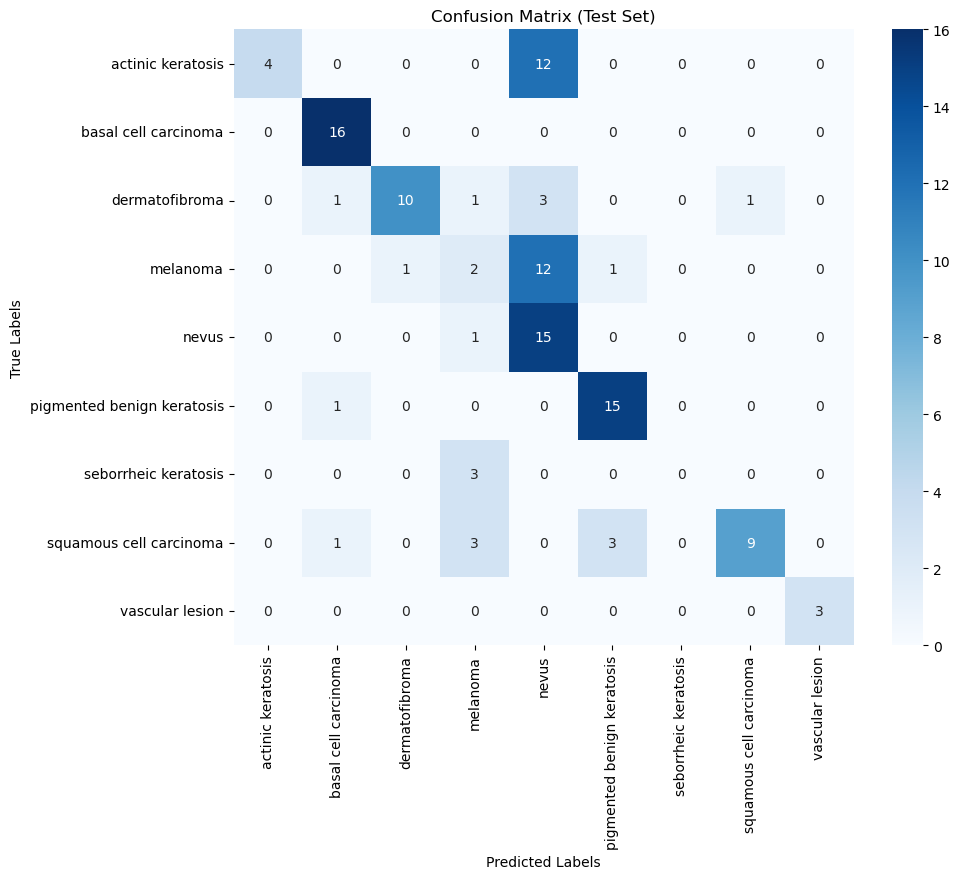

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # Returns an object, not just logits
        
        # Extract logits from the model's output object
        logits = outputs.logits

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute the confusion matrix for test data
cm_test = confusion_matrix(all_labels_test, all_preds_test)

# Check if test_dataset has class names
class_names = test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(len(cm_test))]

# Plot the confusion matrix for test data
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Test Set)')
plt.show()



In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for training data
all_preds_train = []
all_labels_train = []

# Disable gradient computation for training set evaluation
with torch.no_grad():
    for images, labels in train_loader:  # Use train_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # This will return an object, not just logits
        
        # Extract logits (adjust depending on model output structure)
        logits = outputs.logits  

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_train.extend(preds.cpu().numpy())
        all_labels_train.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for training set
f1_train = f1_score(all_labels_train, all_preds_train, average='weighted')  # Use 'macro' for equal class weighting
precision_train = precision_score(all_labels_train, all_preds_train, average='weighted')
recall_train = recall_score(all_labels_train, all_preds_train, average='weighted')

# Print the results
print(f"Training F1 Score: {f1_train:.4f}")
print(f"Training Precision: {precision_train:.4f}")
print(f"Training Recall: {recall_train:.4f}")


Training F1 Score: 0.9450
Training Precision: 0.9462
Training Recall: 0.9481


In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and labels for test data
all_preds_test = []
all_labels_test = []

# Disable gradient computation for test set evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader
        images, labels = images.to(device), labels.to(device)

        # Forward pass through the Swin Transformer model
        outputs = model(images)  # This returns an object, not just logits
        
        # Extract logits from the model's output object
        logits = outputs.logits  

        # Get predicted class
        _, preds = torch.max(logits, 1)

        # Store predictions and labels
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

# Compute F1-score, precision, and recall for the test set
f1_test = f1_score(all_labels_test, all_preds_test, average='weighted')  # Change to 'macro' if needed
precision_test = precision_score(all_labels_test, all_preds_test, average='weighted')
recall_test = recall_score(all_labels_test, all_preds_test, average='weighted')

# Print the results
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test Precision: {precision_test:.4f}")
print(f"Test Recall: {recall_test:.4f}")


Test F1 Score: 0.5457
Test Precision: 0.6804
Test Recall: 0.5847


C:\Users\Amir\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
